In [42]:
from utils import *
from sklearn.impute import KNNImputer

from item_response import irt, sigmoid
from neural_network import device, AutoEncoder, train as train_autoencoder

import torch
from torch.autograd import Variable
import numpy as np
import random as r

BASE_PATH = "./data"
r.seed(2021)


## Data bootstrapping
##
def bootstrap(data, sets=3):
    '''takes data dict from load_train_csv and 
    creates randomized training sets'''
    
    boots = {}
    
    for i in range(sets):
        boots[f"resample{i}"]={
        "user_id": [],
        "question_id": [],
        "is_correct": []
        }

        for j in range(len(data["is_correct"])):
            random_idx= r.randint(0, len(data["is_correct"])-1)
            boots[f"resample{i}"]['user_id'].append(data['user_id'][random_idx])
            boots[f"resample{i}"]['question_id'].append(data['question_id'][random_idx])
            boots[f"resample{i}"]['is_correct'].append(data['is_correct'][random_idx])
    return boots


def dict_to_matrix(data):
    matrix = np.full([542, 1774], np.nan)
    
    for i in range(len(data["is_correct"])):
        user_id = data["user_id"][i]
        question_id = data["question_id"][i]
        c = data["is_correct"][i]
        
        matrix[user_id][question_id] = c
    
    return matrix


## Ensemble
##
class Ensemble():
    def __init__(self):
        self.knn_matrix = None
        self.irt_alpha = None
        self.irt_beta = None
        self.nn_model = None
        self.nn_zero_train_matrix = None
        

def train_knn(model, train_matrix, k):
    # Impute matrix by user
    nbrs = KNNImputer(n_neighbors=k)
    model.knn_matrix = nbrs.fit_transform(train_matrix)


def train_irt(model, train_data, valid_data, lr, num_iterations):
    model.theta, model.beta, _, _, _, _ = irt(train_data, valid_data, lr, num_iterations)


def train_nn(model, train_matrix, valid_data, k, lr, num_epoch, lamb):
    # Prep training data
    model.nn_zero_train_matrix = train_matrix.copy()
    model.nn_zero_train_matrix[np.isnan(train_matrix)] = 0
    model.nn_zero_train_matrix = torch.FloatTensor(model.nn_zero_train_matrix)
    train_matrix = torch.FloatTensor(train_matrix)
    
    # Train AutoEncoder model
    model.nn_model = AutoEncoder(train_matrix.shape[1], k)
    model.nn_model.to(device)
    train_autoencoder(model.nn_model, lr, lamb, train_matrix, model.nn_zero_train_matrix, valid_data, num_epoch)


def train(model, knn_k, irt_lr, irt_iterations, nn_k, nn_lr, nn_epochs, nn_lamb):
    # Load and bootstrap training data
    train_boot = bootstrap(load_train_csv(BASE_PATH))

    knn_train = train_boot["resample0"]
    knn_train_matrix = dict_to_matrix(knn_train)
    irt_train = train_boot["resample1"]
    nn_train = train_boot["resample2"]
    nn_train_matrix = dict_to_matrix(nn_train)
    
    # Load validation data
    valid_data = load_valid_csv(BASE_PATH)
    
    # Train
    train_knn(model, knn_train_matrix, knn_k)
    train_irt(model, irt_train, valid_data, irt_lr, irt_iterations)
    train_nn(model, nn_train_matrix, valid_data, nn_k, nn_lr, nn_epochs, nn_lamb)


def predict(model, query='test', weights=[1/3, 1/3, 1/3], threshold=0.5):
    # Set NN model in evaluation mode
    model.nn_model.eval()
    
    # Load query data
    if query=='validation':
        query_data = load_valid_csv(BASE_PATH)
    elif query == 'test':
        query_data = load_public_test_csv(BASE_PATH)
    
    # Predict
    knn_preds = []
    irt_preds = []
    nn_preds = []
    
    for i in range(len(query_data["is_correct"])):
        user_id = query_data["user_id"][i]
        question_id = query_data["question_id"][i]
        
        # Predict on KNN
        knn_preds.append(model.knn_matrix[user_id][question_id])
        
        # Predict on IRT
        irt_preds.append(sigmoid(model.theta[user_id]-model.beta[question_id]))
        
        # Predict on NN
        inputs = Variable(model.nn_zero_train_matrix[user_id]).unsqueeze(0).to(device)
        output = model.nn_model(inputs)
        nn_preds.append(output[0][question_id].item())
    
    # Bag predictions
    bagged_preds = weights[0]*np.array(knn_preds) + weights[1]*np.array(irt_preds) + weights[2]*np.array(nn_preds) >= threshold
    
    return bagged_preds
    
        
def evaluate(predictions, query="test"):
    # Load query data
    if query == "validation":
        query_data = load_valid_csv(BASE_PATH)
    elif query == "test":
        query_data = load_public_test_csv(BASE_PATH)
    
    # Calculate accuracy
    acc = sum(predictions == query_data["is_correct"])/len(predictions)
    
    return acc

Epoch: 0 	Training Cost: 9013.701546 	Valid Acc: 0.5817104149026249
Epoch: 1 	Training Cost: 8423.352921 	Valid Acc: 0.6138865368331922
Epoch: 2 	Training Cost: 8099.712758 	Valid Acc: 0.6186847304544172
Epoch: 3 	Training Cost: 7935.820836 	Valid Acc: 0.6237651707592435
Epoch: 4 	Training Cost: 7848.221894 	Valid Acc: 0.6230595540502399
Epoch: 5 	Training Cost: 7790.256942 	Valid Acc: 0.6236240474174428
Epoch: 6 	Training Cost: 7742.910754 	Valid Acc: 0.6241885407846458
Epoch: 7 	Training Cost: 7698.994232 	Valid Acc: 0.6260231442280553
Epoch: 8 	Training Cost: 7655.756023 	Valid Acc: 0.6250352808354502
Epoch: 9 	Training Cost: 7612.065225 	Valid Acc: 0.6261642675698561
Epoch: 10 	Training Cost: 7567.382148 	Valid Acc: 0.626728760937059
Epoch: 11 	Training Cost: 7521.391852 	Valid Acc: 0.6271521309624611
Epoch: 12 	Training Cost: 7473.882267 	Valid Acc: 0.6281399943550663
Epoch: 13 	Training Cost: 7424.709974 	Valid Acc: 0.6274343776460627
Epoch: 14 	Training Cost: 7373.795090 	Valid 

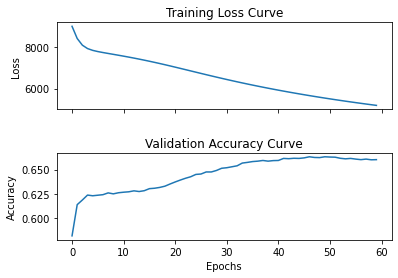

In [44]:
# Set hyperparameters
knn_k = 11

irt_lr = 0.01
irt_iterations = 26

nn_k = 50
nn_lr = 0.01
nn_epochs = 60
nn_lamb = 0.001

# Train model
model = Ensemble()
train(model, knn_k, irt_lr, irt_iterations, nn_k, nn_lr, nn_epochs, nn_lamb)


In [45]:
# Evaluate on validation set
pred_valid = predict(model, query="validation")
acc_valid = evaluate(pred_valid, query="validation")

# Evaluate on test set
pred_test = predict(model, query="test")
acc_test = evaluate(pred_test, query="test")

# Results
print("Validation accuracy=", acc_valid)
print("Test accuracy=", acc_test)

Validation accuracy= 0.689810894721987
Test accuracy= 0.6954558283940163
